---

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

---

# Load data + create classes
We transform the original wine quality scores (0-10) into 4 broader categories. This makes the classification task easier by reducing class imbalance.

In [2]:
df = pd.read_csv("winequality-red.csv")

def map_quality(q):
    if q <= 4:        # Quality 0-4
        return "0-4"
    elif q == 5:      # Quality 5
        return "5"
    elif q == 6:      # Quality 6
        return "6"
    else:             # Quality 7-10
        return "7-10"

df["quality_label"] = df["quality"].apply(map_quality) # Creating a new target column with grouped wine quality categories

X = df.drop(columns=["quality", "quality_label"]) # X contains model features
y = df["quality_label"]                           # y is the new class label to predict

---

# Train-Test split
Splits the data into training and test sets.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=10
)

---

# Synthetic Minority Oversampling (SMOTE) + Balanced SVM Pipeline

In [4]:
pipeline = ImbPipeline([
    ("scaler", StandardScaler()),         # Standardizes all numerical features
    ("smote", SMOTE(random_state=10)),    # Oversamples the minority classes by generating synthetic samples
    ("svm", SVC(kernel="rbf",             # RBF-kernel SVM (nonlinear classifier)
                probability=True,         # enables predict_proba() for AUC and ROC curves
                class_weight="balanced")) # adjusts weights inversely proportional to class frequencies
])

---

# Hyperparameter Tuning (GridSearchCV)

In [5]:
param_grid = {
    "svm__C": [1, 5, 10, 50, 100, 200, 500, 1000], # Regularization strength: higher C reduces margin and fits harder
    "svm__gamma": ["scale", 0.1, 0.05, 0.03, 0.01, 0.005, 0.001] # Kernel width: controls the influence a single point can reach
}

# GridSearchCV trains multiple SVM models with different C and gamma combinations and evaluates their performance
grid = GridSearchCV(
    estimator=pipeline,    # The full pipeline: scaling → SMOTE → SVM
    param_grid=param_grid, # Hyperparameters to test
    cv=5,                  # 5-fold cross-validation for reliable model evaluation
    scoring="f1_macro",    # Macro-F1 gives equal weight to all classes
    n_jobs=-1              # Use all CPU cores
)

grid.fit(X_train, y_train) # Fit the GridSearchCV on the training data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=10)),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 5, 10, 50, 100, 200, 500, 1000],
                         'svm__gamma': ['scale', 0.1, 0.05, 0.03, 0.01, 0.005,
                                        0.001]},
             scoring='f1_macro')

---

# Results

Best params: {'svm__C': 5, 'svm__gamma': 0.1}
AUC (micro): 0.8447721354166666
AUC (macro): 0.7719509153153259
AUC (weighted): 0.7804035798519784


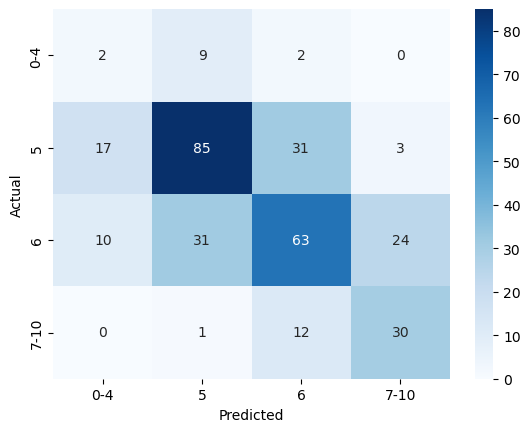

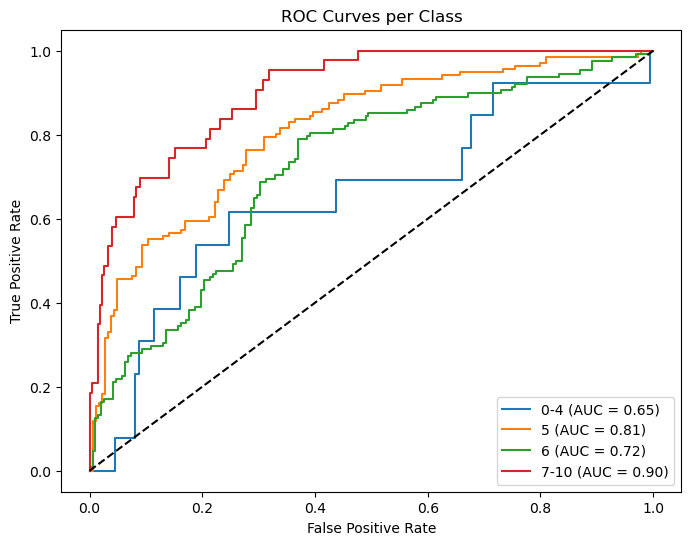

In [6]:
print("Best params:", grid.best_params_)

# Predicting on the best model -----------------------------------------------------------
best_model = grid.best_estimator_          # Extract the best pipeline returned by GridSearchCV
y_pred = best_model.predict(X_test)        # Predicted classes for the test set
y_proba = best_model.predict_proba(X_test) # Predicted probabilities for the test set


# ROC-AUC curves -------------------------------------------------------------------------
labels = ["0-4", "5", "6", "7-10"]
y_test_bin = label_binarize(y_test, classes=labels) # Convert class labels to binary format

# Micro AUC:
# Computes AUC globally by counting all true positives / false positives together.
auc_micro = roc_auc_score(
    y_test_bin, y_proba,
    average="micro",
    multi_class="ovr")

# Macro AUC:
# Computes AUC for each class separately and takes the unweighted mean (all classes equal).
auc_macro = roc_auc_score(
    y_test_bin, y_proba,
    average="macro",
    multi_class="ovr")

# Weighted AUC:
# Computes AUC for each class and averages them weighted by class frequency.
auc_weighted = roc_auc_score(
    y_test_bin,
    y_proba, average="weighted",
    multi_class="ovr")

print("AUC (micro):", auc_micro)
print("AUC (macro):", auc_macro)
print("AUC (weighted):", auc_weighted)

# Confusion Matrix -----------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=labels) # FOr comparing predicted vs actual

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels
) # Visualizes the confusion matrix as a heatmap

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Plot ROC curves per class --------------------------------------------------------------
plt.figure(figsize=(8,6))
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i]) # ROC curve points (false positive rate, true positive rate)
    auc_val = roc_auc_score(y_test_bin[:, i], y_proba[:, i]) # AUC value for this specific class
    plt.plot(fpr, tpr, label=f"{lab} (AUC = {auc_val:.2f})") # Plot ROC curve for the class

plt.plot([0,1], [0,1], "k--") # Diagonal line representing a random classifier
plt.title("ROC Curves per Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

---

# Permutation Feature Importance

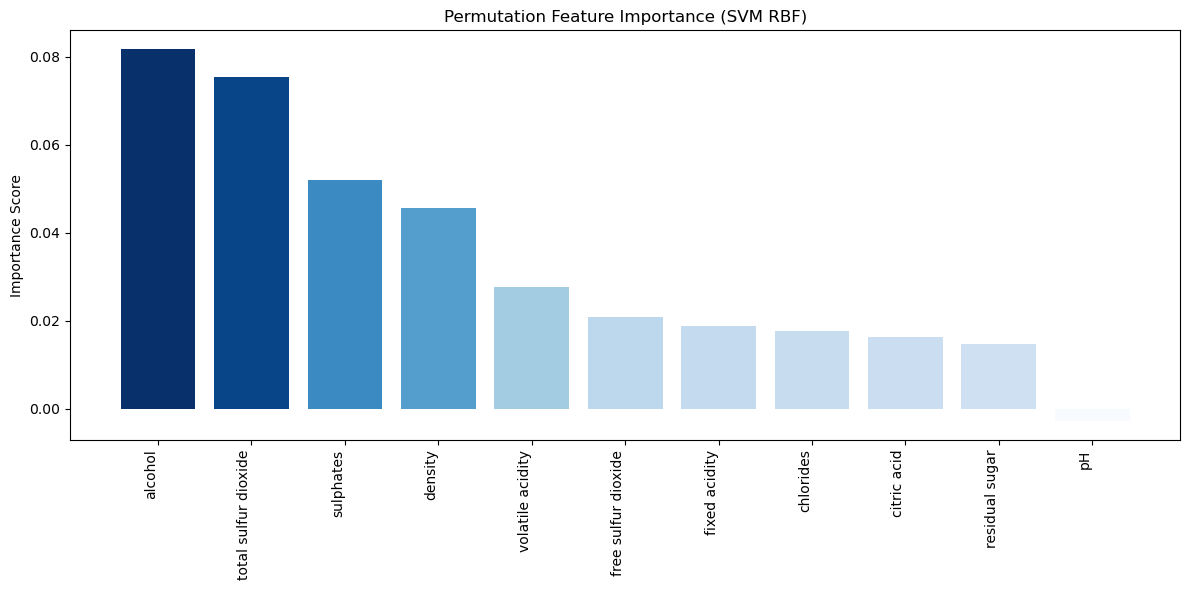

In [7]:
perm = permutation_importance(
    best_model,            # The trained pipeline: scaler + SMOTE + SVM
    X_test,
    y_test,
    scoring="f1_weighted", # Metric used to measure importance
    n_repeats=20,          # Number of shuffles for each feature
    random_state=10        # Ensures reproducibility
)

importances = perm.importances_mean     # Average importance score for each feature
indices = np.argsort(importances)[::-1] # Sort features from most to least important

# Heatmap style colors --------------------------------------------------
norm = mpl.colors.Normalize(vmin=min(importances), vmax=max(importances)) # Normalize values to 0–1
cmap = mpl.cm.Blues # Color
colors = cmap(norm(importances[indices])) # Gradient

# Plot ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(
    range(len(importances)),
    importances[indices],
    color=colors
)

plt.xticks(range(len(importances)), X.columns[indices], rotation=90, ha="right")
plt.ylabel("Importance Score")
plt.title("Permutation Feature Importance (SVM RBF)")
plt.tight_layout()
plt.show()

---